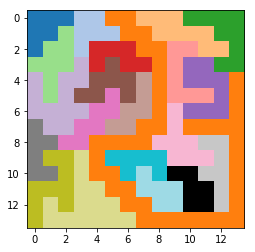

In [395]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


x = [ 
        [1,1,1,2,2,3,3,4,4,4,5,5,5,5],
        [1,1,6,2,2,2,3,3,4,4,4,4,5,5],
        [1,6,6,2,7,7,7,3,3,8,8,4,4,5],
        [6,6,6,10,7,11,7,7,3,8,9,9,5,5],
        [10,6,10,10,11,11,11,12,3,8,9,9,9,3],
        [10,6,10,11,11,13,11,12,3,8,8,8,9,3],
        [10,10,10,10,13,13,12,12,3,14,9,9,9,3],
        [15,10,10,13,13,12,12,3,3,14,3,3,3,3],
        [15,15,13,13,3,3,3,3,14,14,14,16,16,3],
        [15,17,17,18,3,19,19,19,19,14,14,14,16,3],
        [15,15,17,18,3,3,19,20,19,21,21,16,16,3],
        [17,17,17,18,18,3,3,20,20,20,21,21,16,3],
        [17,18,17,18,18,18,3,3,20,20,21,21,16,3],
        [17,18,18,18,18,18,18,3,3,3,3,3,3,3,]
    ]   

og = matplotlib.cm.get_cmap(name="tab20")
colors = list(og.colors) + [(0,0,0)]
c = matplotlib.colors.ListedColormap(colors, name='my_name')
plt.imshow(x, cmap=c)
plt.show()

In [396]:
import itertools

n = 14

def ind(r,c):
    return r*n + c + 1 # picosat 1-indexes
def rc(ind):
    return (ind-1) // n, (ind-1) % n

def rot_sym(rot_n, offr, offc):
    res = []
    banned = set(range(1, n**2+1))
    for i in range(offr, (rot_n+1)/2):
        for j in range(offc, (rot_n+1)/2):
            ul = (i+offr,j+offc)
            ur = (j+offr,rot_n-1-i+offc)
            bl = (rot_n-1-j+offr,i+offc)
            br = (rot_n-1-i+offr,rot_n-1-j+offc)
            for comb in itertools.combinations([ul, ur, bl, br], 2):
                ind0 = ind(*comb[0])
                ind1 = ind(*comb[1])
                res.append("-{} {} 0".format(ind0, ind1))
                res.append("{} -{} 0".format(ind0, ind1))
                if ind0 in banned:
                    banned.remove(ind0)
                if ind1 in banned:
                    banned.remove(ind1)
    for b in banned:
        res.append("-{} 0".format(b))
    return res

def connected(n=14):
    res = []
    for i in range(n):
        for j in range(n):
            def neighbors(r,c):
                nbs = set()
                if r > 0:
                    nbs.add((r-1,c))
                if c > 0:
                    nbs.add((r,c-1))
                if r < n-1:
                    nbs.add((r+1,c))
                if c < n-1:
                    nbs.add((r,c+1))
                return nbs
            nbs = neighbors(i,j)
            inds = map(lambda x: ind(*x), nbs)
            s = "-{} ".format(ind(i,j))
            for var in inds:
                s += "{} ".format(var)
            s += "0"
            res.append(s)
    return res

In [397]:
def nchoosek(arr, k):
    n = len(arr)
    res = []
    
    # pigeonholeish encodings
    # encoding at least k: all combinations of size n-k+1 needs at least 1 true
    import itertools
    for c in itertools.combinations(arr, n-k+1):
        encoding = []
        for var in c:
            encoding.append("{} ".format(var))
        encoding.append("0")
        res.append("".join(encoding))
    # encoding at most k: all combinations of size k+1 needs at least 1 false
    for c in itertools.combinations(arr, k+1):
        encoding = []
        for var in c:
            encoding.append("-{} ".format(var))
        encoding.append("0")
        res.append("".join(encoding))
    return res

from collections import defaultdict
hm = defaultdict(set)
for i, arr in enumerate(x):
    for j, group in enumerate(arr):
        hm[group].add(ind(i,j))
hm = dict(hm)

def k_in_group(k):
    res = []
    for group in hm:
        res.extend(nchoosek(hm[group], k))
    return res

In [398]:
def encode(nck_list, rot_n, offr, offc, extras=[]):
    fname = "js.cnf"
    num_vars = 196
    encodings = rot_sym(rot_n, offr, offc) + connected() + nck_list + extras
    with open(fname, 'w') as fout:
        header = "p cnf {} {}".format(num_vars, len(encodings))
        fout.write(header)
        fout.write("\n")
        for e in encodings:
            fout.write(e)
            fout.write("\n")

In [399]:
from subprocess import Popen, PIPE

def run_sat_solver(file_name='js.cnf'):
    p = Popen(['./picosat', file_name], stdin=PIPE, stdout=PIPE, stderr=PIPE)
    output, err = p.communicate(b"input data that is passed to subprocess' stdin")
    rc = p.returncode
    return cleanup(output)

def cleanup(s):
    s = s.replace("\nv", "")
    s = s.replace("s SATISFIABLE ", "")
    s = s.replace("s UNSATISFIABLE\n", "")
    s = s.replace(" 0\n", "")
    return s if s != '' else None

def solve(file_name='js.cnf'):
    sat = run_sat_solver(file_name=file_name)
    if sat == None:
        return None
    sat = sat.split(" ")
    return sat

def sat_grid(sat):
    g = [[0]*14 for _ in range(14)]
    for assignment in sat:
        r, c = rc(abs(int(assignment)))
        if int(assignment) < 0:
            g[r][c] = 0
        else:
            g[r][c] = 1
    return g

def get_extra(sat):
    extra = []
    for v in sat:
        extra.append("{} ".format(-int(v)))
    extra.append("0")
    return "".join(extra)
            
def area(solution):
    solution = map(lambda row: map(lambda el: 1 if el == 0 else 0, row), solution)
    from scipy.ndimage import measurements
    labels, num = measurements.label(solution)
    areas = measurements.sum(solution, labels, index=range(1, num+1))
    print areas
    return reduce(lambda x,y: x*y, areas)

In [400]:
sols = []
extras = []
while True:
    encode(k5, 13, 0, 0, extras=extras)
    sat = solve()
    if sat is None:
        print "Done"
        break
    g = sat_grid(sat)
    a = area(g)
    e = get_extra(sat)
    extras.append(e)
    sols.append((a, g))
    print a

[ 11.  49.   2.   1.   2.  11.   1.   2.   2.   2.   2.   1.   2.   2.   1.]
1517824.0
[ 10.   1.  49.   2.   1.   2.   1.  10.   1.   2.   2.   2.   2.   1.   2.
   2.   1.]
1254400.0
[ 10.  47.   2.   1.   2.  10.   1.   1.   2.   1.   2.   2.   1.   2.   1.
   1.   2.   2.   1.]
1203200.0
Done


In [401]:
sols[-1][1]

[[1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0],
 [1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0],
 [1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0],
 [1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0],
 [0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0],
 [0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0],
 [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0],
 [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0],
 [1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0],
 [1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0],
 [1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0],
 [1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

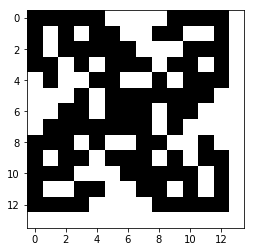

In [402]:
g = sols[-1][1]
asdf = matplotlib.cm.get_cmap(name="tab10")
colors = ['w', 'k'] 
c = matplotlib.colors.ListedColormap(colors, name='my_name')
plt.imshow(g, cmap=c)
plt.show()